In [291]:
import pandas as pd
import numpy as np
from datetime import date
import math
from scipy import special
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

In [292]:
df = pd.read_csv('./owid-covid-data.csv')
df['date'] = pd.to_datetime(df['date'])

In [293]:
df_russia = df[(df['location'] == 'Russia') & (df['date'] >= pd.Timestamp('2020-03-03'))].reset_index().drop(columns=['index'])
df_russia.loc[df_russia['new_cases'] == 0, 'new_cases'] = 1
df_russia['day_from_start'] = df_russia.index
df_russia

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,day_from_start
0,RUS,Europe,Russia,2020-03-03,3.0,1.0,0.143,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,0
1,RUS,Europe,Russia,2020-03-04,3.0,1.0,0.143,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,1
2,RUS,Europe,Russia,2020-03-05,4.0,1.0,0.286,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,2
3,RUS,Europe,Russia,2020-03-06,13.0,9.0,1.571,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,3
4,RUS,Europe,Russia,2020-03-07,13.0,1.0,1.571,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,RUS,Europe,Russia,2022-02-14,14102736.0,178785.0,188563.571,334093.0,672.0,689.857,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,713
714,RUS,Europe,Russia,2022-02-15,14267875.0,165139.0,188712.429,334785.0,692.0,690.571,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,714
715,RUS,Europe,Russia,2022-02-16,14445698.0,177823.0,188145.571,335521.0,736.0,701.714,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,715
716,RUS,Europe,Russia,2022-02-17,14624423.0,178725.0,185778.714,336299.0,778.0,714.143,...,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN,716


In [294]:
n_days_for_train = 50
df_train = df_russia.loc[df_russia['date'] <= pd.Timestamp('2020-03-03') + pd.DateOffset(days=n_days_for_train)]
df_test = df_russia.loc[df_russia['date'] > pd.Timestamp('2020-03-03') + pd.DateOffset(days=n_days_for_train)].reset_index().drop(columns=['index'])

<AxesSubplot:xlabel='day_from_start'>

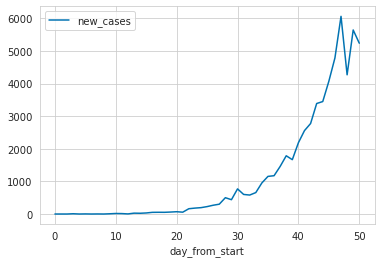

In [295]:
df_train.plot.line(x='day_from_start', y='new_cases')

<AxesSubplot:xlabel='day_from_start'>

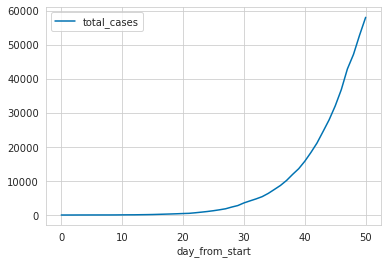

In [296]:
df_train.plot.line(x='day_from_start', y='total_cases')

Пусть зависимость описывается уравнением y = c * exp(a * x + b)
Возмем логарифм от обеих частей, получим ln y = ln c + a * x + b, т.е. линейную зависимость, строим стандартную линейную регрессию и получаем значения коэффициентов

In [297]:
from sklearn.linear_model import LinearRegression
t = np.array(df_train['day_from_start'])
t_test = np.array(df_test['day_from_start'])
reg = LinearRegression().fit(t.reshape((n_days_for_train + 1,1)), np.log(df_train['total_cases']))
print(reg.coef_)
print(reg.intercept_)

[0.19655539]
1.8490840448339725


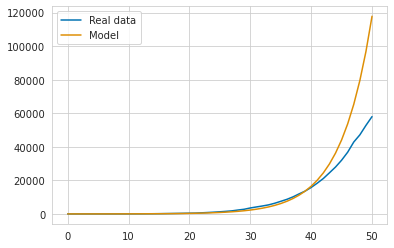

In [298]:
_, ax = plt.subplots()
ax.plot(t, df_train['total_cases'], label='Real data')
ax.plot(np.exp(reg.coef_[0] * t + reg.intercept_), label='Model')
ax.legend()
plt.show()

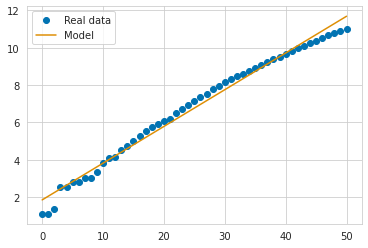

In [299]:
_, ax = plt.subplots()
ax.plot(t, np.log(df_train['total_cases']), 'o', label='Real data')
ax.plot(reg.coef_[0] * t + reg.intercept_, label='Model')
ax.legend()
plt.show()

Можно построить распределение значений ошибки и оценить среднее и дисперсию

(array([ 2.,  1.,  2.,  1.,  3.,  3.,  4.,  4.,  5.,  7.,  5., 14.]),
 array([-0.94702714, -0.83240874, -0.71779034, -0.60317194, -0.48855354,
        -0.37393514, -0.25931674, -0.14469834, -0.03007994,  0.08453846,
         0.19915686,  0.31377526,  0.42839366]),
 <BarContainer object of 12 artists>)

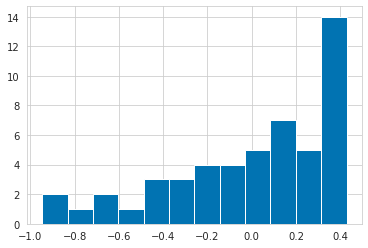

In [300]:
deltas = np.log(df_train['total_cases']) - reg.coef_[0] * t - reg.intercept_
counts, bins = np.histogram(deltas, bins=12)
plt.hist(bins[:-1], bins, weights=counts)

In [301]:
print(np.mean(deltas))
print(np.std(deltas))

4.615044729814377e-16
0.3606950505316904


In [302]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.5):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

Возьмем в качесте априорного распределения гаусс с центром в нуле и достаточно широкий
и будем добавлять по одной точке и пересчитывать параметры апостериорного распределения

In [303]:
curr_mu, curr_sigma = np.array([0, 0]), np.array([[0.36, 0], [0, 0.36]])
for idx in range(len(t)):
    curr_mu, curr_sigma = bayesian_update(curr_mu, curr_sigma, t[idx], np.log(df_train['total_cases'])[idx])
print(curr_mu)
print(curr_sigma)

[1.75648761 0.19930255]
[[ 1.80847916e-02 -5.37163339e-04]
 [-5.37163339e-04  2.17791062e-05]]


Для получившихся значений $\mu$ и $\sigma$ можно построить распределение

<ipython-input-304-370f0bc4e239>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)


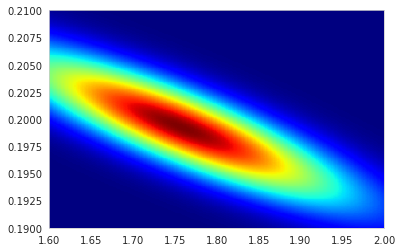

In [304]:
from scipy.stats import multivariate_normal
N = 250
xs = np.linspace(0, 50, N)
xs_with_test = np.linspace(0, 200, N)
X = np.linspace(1.6, 2.0, N)
Y = np.linspace(0.19, 0.21, N)
X, Y = np.meshgrid(X, Y)

def myplot_heatmap(Z):
    #plt.axis('equal')
    plt.xlim((1.6, 2.0))
    plt.ylim((0.19, 0.21))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    plt.scatter(0, 0, marker='o', s=40)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
Z = multivariate_normal.pdf(pos, mean=curr_mu, cov=curr_sigma)

myplot_heatmap(Z)

In [305]:
def sample_lines(xs, y_max, mu, sigma, n=20, points=None, points_test=None):
    _, ax = plt.subplots()
    my_w = np.random.multivariate_normal(mu, sigma, n)

    for w in my_w:
        plt.plot(xs, w[0] + w[1]*xs, 'k-', lw=.4)
    plt.xlabel('Days from start')
    plt.ylabel('Log(Total cases)')
    plt.ylim((0, y_max))
    plt.xlim((0, xs.max()))
    if not points is None:
        ax.scatter(points[0], points[1], marker='o', s=40, label='train')
    if not points_test is None:
        ax.scatter(points_test[0], points_test[1], marker='o', s=40, label='test')
    ax.legend()
    plt.show()

In [306]:
def sample_lines_exp(xs, y_max, mu, sigma, n=20, points=None, points_test=None):
    _, ax = plt.subplots()
    my_w = np.random.multivariate_normal(mu, sigma, n)

    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1]*xs), 'k-', lw=.4)
    plt.xlabel('Days from start')
    plt.ylabel('Total cases')
    plt.ylim((0, y_max))
    plt.xlim((0, xs.max()))
    if not points is None:
        ax.scatter(points[0], np.exp(points[1]), marker='o', s=40, label='train')
    if not points_test is None:
        ax.scatter(points_test[0], np.exp(points_test[1]), marker='o', s=40, label='test')
    ax.legend()
    plt.show()

In [307]:
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
    return res

In [308]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()

In [309]:
def plot_predictions(xs, mu, x, points):
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)
    ax.set_xlim((0, 50))
    ax.set_ylim((0, 12))
    ax.plot(xs, mu[1]*xs + mu[0], color="red", label="MAP гипотеза")
    ax.fill_between(xs, mu[1]*xs + mu[0] - .25, mu[1]*xs + mu[0] + .25, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(points[0], points[1], marker='o', s=40)
    ax.legend(fontsize=16)

Построим набор сэмплов из получившегося распределения в логарифмической шкале

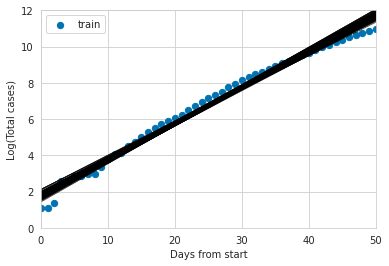

In [310]:
sample_lines(xs, 12, curr_mu, curr_sigma, 200, points=[t, np.log(df_train['total_cases'])])

Добавим тестовые данные, видно, что предсказание лежит сильно выше тестовых данных

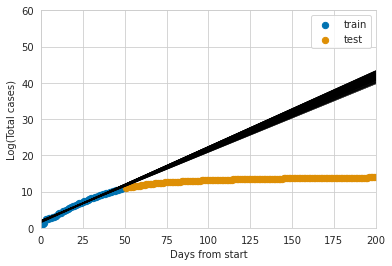

In [311]:
sample_lines(xs_with_test, 60, curr_mu, curr_sigma, 200, points=[t, np.log(df_train['total_cases'])], points_test=[t_test, np.log(df_test['total_cases'])])

Аналогичные графики для исходной шкалы

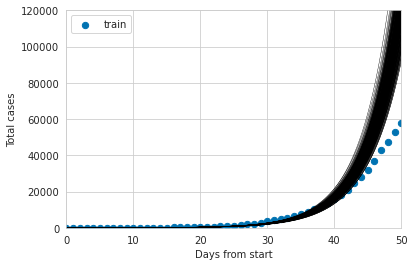

In [312]:
sample_lines_exp(xs, 120000, curr_mu, curr_sigma, 200, points=[t, np.log(df_train['total_cases'])])

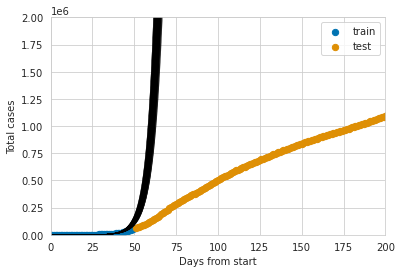

In [313]:
sample_lines_exp(xs_with_test, 2000000, curr_mu, curr_sigma, 200, points=[t, np.log(df_train['total_cases'])], points_test=[t_test, np.log(df_test['total_cases'])])

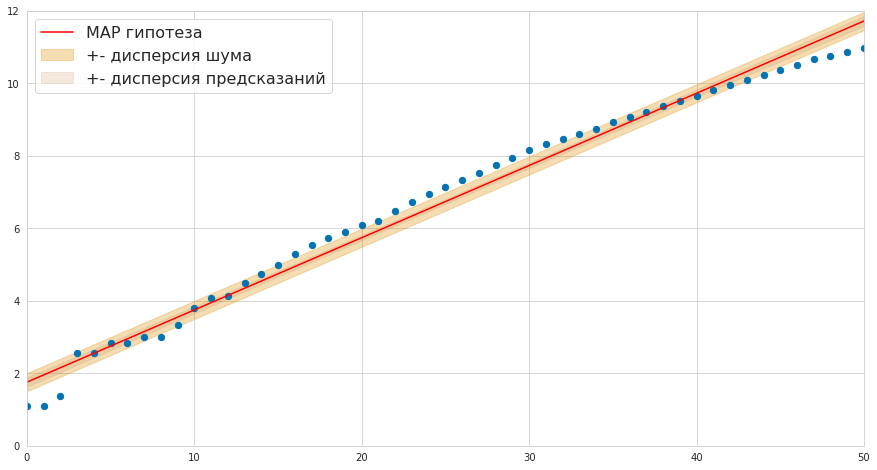

In [314]:
x = sample_statistics(curr_mu, curr_sigma, xs, n=1000)
plot_predictions(xs, curr_mu, x, [t, np.log(df_train['total_cases'])])

In [315]:
def plot_predictions_exp(xs, mu, x, points):
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)
    ax.set_xlim((0, 50))
    ax.set_ylim((0, 120000))
    ax.plot(xs, np.exp(mu[1]*xs + mu[0]), color="red", label="MAP гипотеза")
    ax.fill_between(xs, np.exp(mu[1]*xs + mu[0] - .25), np.exp(mu[1]*xs + mu[0] + .25), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.exp(np.mean(x, axis=0) - np.std(x, axis=0)), np.exp(np.mean(x, axis=0) + np.std(x, axis=0)), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(points[0], np.exp(points[1]), marker='o', s=40)
    ax.legend(fontsize=16)

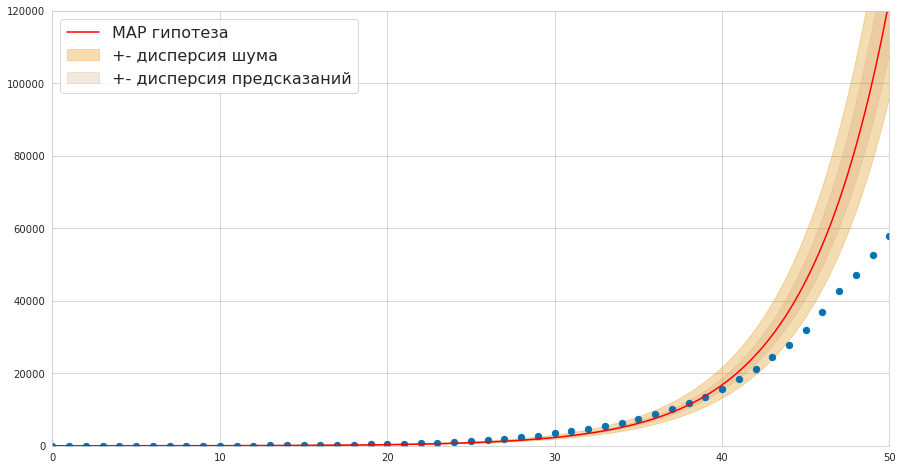

In [316]:
plot_predictions_exp(xs, curr_mu, x, [t, np.log(df_train['total_cases'])])

Значения на заданные даты, видно, что они неправдоподобны

In [317]:
dates = ['2020-05-01', '2020-06-01', '2020-09-01']
for date in dates:
    date_count = np.array(df_test.loc[df_test['date'] == pd.Timestamp(date)]['day_from_start'])[0]
    predict = np.exp(curr_mu[1] * date_count + curr_mu[0])
    print(f'Total cases predicted for {date}: {predict}')

Total cases predicted for 2020-05-01: 740690.5703376547
Total cases predicted for 2020-06-01: 357168199.31233376
Total cases predicted for 2020-09-01: 3.281139468120797e+16


Попробуем использовать в качестве модели сигмоиду вида: c$\int_{-\infty}^x$exp(-$(at+b)^2$)dt

In [318]:
def sigmoid(w):
    rv = norm()
    l = 0
    for ti in t:
        l += (w[0] * rv.cdf(w[2] * ti + w[1]) - df_train['total_cases'][ti])**2
    return l

Т.к. максимизация правдоподобия эквивалентна минимизации суммы квадратов разностей, то можно найти коэффициенты с помощью функции minimize

In [319]:
res = minimize(sigmoid, [100000.0, -9.0, 0.2], method='nelder-mead', options={'disp': True})
res.x

array([ 6.30883372e+05, -4.46873114e+00,  6.29730965e-02])

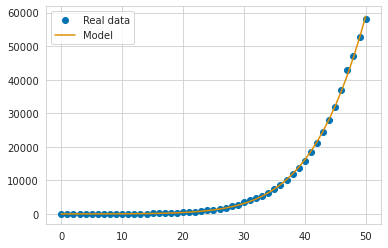

In [320]:
rv = norm()
_, ax = plt.subplots()
ax.plot(t, df_train['total_cases'], 'o', label='Real data')
ax.plot(t, res.x[0] * rv.cdf(res.x[2] * t + res.x[1]), label='Model')
ax.legend()
plt.show()

В данном случае можно свести задачу к линейной регрессии, если разложить сигмоиду в ряд

$\Phi$(x) = $\frac{1}{\sqrt{2\pi}}\int_{-\infty}^xe^{-\frac{t^2}{2}}dt$=
$\frac{1}{2}(1 + erf(\frac{x}{\sqrt{2}}))$, где erf - функция ошибок

или в более общем виде

$y = c(1 + erf(ax + b))=c(1 + \frac{2}{\sqrt{\pi}}((ax + b) - \frac{(ax + b)^3}{3} + \frac{(ax + b)^5}{10} - \frac{(ax + b)^7}{42} + \frac{(ax + b)^9}{216} - ...)$

это можно переписать в виде

$y = cf_0(b) + cf_1(b)ax + cf_2(b)a^2x^2+..., где f_i(b)$ - полином от b с известными коэффициентами

т.е. это можно представить в виже w*x, где x=$[1, x, x^2, x^3...]$, а w - вектор, определяемый параметрами a,b и c

In [321]:
def ci(i, b, n_poly):
    res = 0
    for idx in range(n_poly):
        if i <= (2 * idx + 1):
            res += ((-1) ** idx) / math.factorial(idx) / (2 * idx + 1) * special.binom(2 * idx + 1, i) * (b ** (2 * idx + 1 - i))
    return res

In [322]:
def poly_ci(x, w, n_poly):
    a, b, c = w
    res = 0.0
    for ni in range(n_poly):
        res += ((a * x) ** ni) * ci(ni, b, n_poly)
    return c * (res * 2 / (math.pi ** 0.5) + 1.0)

In [370]:
def poly_l(w):
    n_poly = 10
    l = 0
    for ti in t:
        l += (poly_ci(ti, w, n_poly) - df_train['total_cases'][ti]) ** 2
    return l

Если ограничиться разложением до 9 степени, то можно найти a,b и с

In [371]:
n_poly = 10
res_p = minimize(poly_l, [ 0.0025, -10,  150], method='nelder-mead', options={'disp': True})
res_p.x

array([-1.93610352e-02, -1.94294552e+00,  1.39054020e+03])

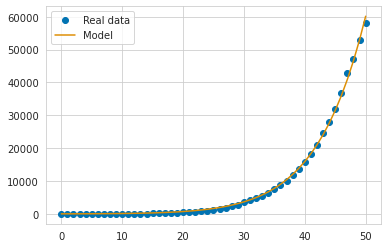

In [372]:
rv = norm()
_, ax = plt.subplots()
ax.plot(t, df_train['total_cases'], 'o', label='Real data')
ax.plot(t, [poly_ci(ti, res_p.x, n_poly) for ti in t], label='Model')
ax.legend()
plt.show()

Тогда w будет

In [373]:
a, b, c = res_p.x
w = []
for i in range(n_poly):
    w.append(ci(i, b, n_poly) * (a ** i) * c * 2 / (math.pi ** 0.5))
w[0] += c
w

[26.165786800389924,
 2.9452572375523967,
 0.3795325737820296,
 0.021058561553169333,
 0.0009440962124938001,
 3.043844532183028e-05,
 7.732047515743774e-07,
 1.564843611764709e-08,
 2.559035269617665e-10,
 3.4157460355870923e-12]

В данном случае нельзя считать, что все параметры в w независимы, так как независимыми будут только три параметра, можно попробовать считать, что $\Sigma_n$ будет иметь значения близкие к нулю везде, кроме блока 3*3 и добавляя по одной точке, найти $\Sigma_n$ на n-ом шаге

In [374]:
def bayesian_update_sigma(sigma, x, y, sigma_noise=.5):
    arr = []
    for i in range(n_poly):
        arr.append(x ** i)
    x_matrix = np.array([arr])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    return sigma_n

In [375]:
curr_mu, curr_sigma = np.array(w), np.eye(n_poly) * 0.01
for i in range(2):
    curr_sigma[i, i] = 1.0
for idx in range(len(t)):
    curr_sigma = bayesian_update_sigma(curr_sigma, t[idx], df_train['total_cases'][idx])
print(curr_sigma)

[[ 3.81297126e-02 -2.88716136e-03  4.44314877e-05  4.00768693e-09
   1.03140473e-10  2.72514275e-12  7.39842834e-14  2.05563519e-15
   5.72390498e-17  1.45466325e-18]
 [-2.88716238e-03  2.95690304e-04 -5.02949727e-06 -5.99944809e-10
  -1.57528883e-11 -4.27701708e-13 -1.20721122e-14 -3.56234653e-16
  -1.10238670e-17 -3.72902206e-19]
 [ 4.44315099e-05 -5.02949775e-06  8.77495003e-08  1.10753804e-11
   2.91792546e-13  7.95773725e-15  2.25985499e-16  6.73836710e-18
   1.94784609e-19  1.86511292e-20]
 [ 4.00769088e-09 -5.99945000e-10  1.10753827e-11  1.56179019e-15
   4.13809820e-17  1.13100864e-18  4.23650290e-20 -1.56602488e-20
   1.16663652e-20 -2.42519518e-22]
 [ 1.03140578e-10 -1.57528935e-11  2.91792610e-13  4.13809825e-17
   1.09068274e-18  3.98842173e-20 -1.57809507e-20  1.16608108e-20
  -2.42775648e-22 -1.23745842e-26]
 [ 2.72514569e-12 -4.27701858e-13  7.95773910e-15  1.13100867e-18
   3.98842177e-20 -1.58173753e-20  1.16584489e-20 -2.42897909e-22
  -1.83903232e-26 -3.03834298e-28

In [383]:
def sample_lines_sigmoid(xs, y_max, mu, sigma, n=20, points=None, points_test=None):
    _, ax = plt.subplots()
    my_w = np.random.multivariate_normal(mu, sigma, n)

    res_full = []
    for w in my_w:
        res = 0
        for i in range(n_poly):
            res += w[i] * (xs ** i)
        res_full.append(res)
        plt.plot(xs, res, 'k-', lw=.4)
    plt.plot(xs, np.mean(res_full, axis=0), 'r-', lw=.8)
    plt.xlabel('Days from start')
    plt.ylabel('Total cases')
    plt.ylim((0, y_max))
    plt.xlim((0, xs.max()))
    if not points is None:
        ax.scatter(points[0], points[1], marker='o', s=40, label='train')
    if not points_test is None:
        ax.scatter(points_test[0], points_test[1], marker='o', s=40, label='test')
    ax.legend()
    plt.show()

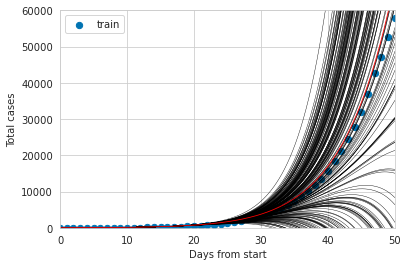

In [378]:
sample_lines_sigmoid(xs, 60000, curr_mu, curr_sigma, 200, points=[t, df_train['total_cases']])

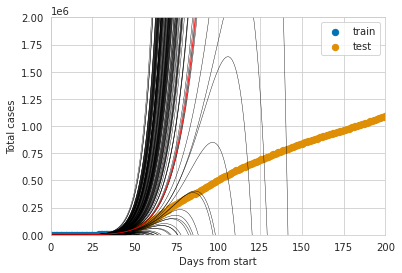

In [381]:
sample_lines_sigmoid(xs_with_test, 2000000, curr_mu, curr_sigma, 200, points=[t, df_train['total_cases']], points_test=[t_test, df_test['total_cases']])

Модель на основе полиномиального разложения сигмоиды дает менее резкий рост, но так как для обучения используется только небольшой кусок данных, на которых происходит рост функции и в который не попадают данные относящиеся к перегибу функции, предиктивность такой модели получается довольно ограниченной. Кроме того, использование конечного набора степеней приводит к тому, что при большом сдвиге по дате, результат разложения в ряд сильно отличается от исходной сигмоиды.